<a href="https://colab.research.google.com/github/Urmilakoli/msc-circular-economy-analytics/blob/main/Data_Analysis_of_jwellery_business.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas        # Excel-like data manipulation in Python
!pip install numpy         # Mathematical operations on arrays
!pip install scipy         # Statistical tests (chi-square, t-test)
!pip install statsmodels   # Advanced statistical modeling
!pip install scikit-learn  # Machine learning (Random Forest)
!pip install matplotlib    # Basic plotting
!pip install seaborn       # Beautiful statistical visualizations

In [3]:
# Test if libraries installed correctly
import pandas as pd
import numpy as np
from scipy import stats
import sklearn
import matplotlib.pyplot as plt

print("All libraries installed successfully! ✅")

All libraries installed successfully! ✅


In [57]:
# ============================================
# DATA PREPARATION SCRIPT
# ============================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import re # Import regex module for column cleaning

# ------------------------------------------
# STEP 1: LOAD DATA
# ------------------------------------------

# Load survey responses from CSV file
df = pd.read_excel('/content/Consumer_Preferences_survey.csv.xlsx')

# Clean column names by stripping whitespace and removing common invisible characters
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace('​', '', regex=False) # Remove zero-width space
df.columns = df.columns.str.replace(' ', ' ', regex=False).str.strip() # Replace non-breaking space with regular space, then strip
df.columns = df.columns.str.replace(r'\s+', ' ', regex=True).str.strip() # Replace multiple whitespaces with single space and strip again

# Display first few rows to verify
print("First 5 rows of raw data:")
print(df.head())

# Print all column names after cleaning for debugging
print("\nCleaned DataFrame Column Names (repr()):")
for col_name in df.columns.tolist():
    print(repr(col_name))

# Check data dimensions
print(f"\nDataset shape: {df.shape}")  # (rows, columns)
print(f"Number of responses: {len(df)}")

# ------------------------------------------
# STEP 2: HANDLE MISSING VALUES
# ------------------------------------------

# Check for missing values in each column
print("\nMissing values before cleaning:")
print(df.isnull().sum())

# Count rows with ANY missing values
missing_rows = df.isnull().any(axis=1).sum()
print(f"\nRows with missing data: {missing_rows}")

# Define patterns for essential columns. We'll find these in df.columns.
essential_column_patterns = [
    '1. What is your age group?',
    '2.What is your education level?',
    '4.What is your gender?',
    '5.What is your annual household income (INR /EURO)?',
    '10.How important is sustainability when purchasing jewellery?',
    '14.Would you pay MORE for jewellery made from sustainable materials?', # For Premium_Numeric
    '12. Have you ever purchased sustainable jewellery?'                   # For Sustainable_Purchaser
    # Removed '15.If a jewellery brand offered a buyback program for old jewellery, would you be interested?' as it doesn't exist
]

essential_columns = []
for pattern in essential_column_patterns:
    found_col = None
    for col_name in df.columns.tolist(): # Iterate through the actual cleaned column names
        if pattern in col_name: # Check if the pattern is a substring of the column name
            essential_columns.append(col_name)
            found_col = col_name
            break # Move to the next pattern once a match is found
    if not found_col:
        print(f"Warning: Could not find a column matching pattern: {pattern!r}. Skipping.")

# Print the essential columns for comparison (repr() for exact match)
print("\nEssential Columns being checked (repr()):")
for col_name_essential in essential_columns:
    print(f"Essential: {repr(col_name_essential)}")
    if col_name_essential not in df.columns:
        print(f"    *** NOT FOUND IN DF COLUMNS ***")
        for df_col in df.columns:
            # Try a partial match to help identify the discrepancy
            if col_name_essential in df_col or df_col in col_name_essential:
                print(f"        Closest DF column (repr()): {repr(df_col)}")
                break

# Remove rows with missing values only for columns essential for this analysis
df_clean = df.dropna(subset=essential_columns).copy()

print(f"\nRows after removing missing: {len(df_clean)}")

# Alternative: Fill missing with median (if needed)
# df['Age'] = df['Age'].fillna(df['Age'].median())

# ------------------------------------------
# STEP 3: ENCODE CATEGORICAL VARIABLES
# ------------------------------------------

# Gender: Convert Male/Female to 1/0
le_gender = LabelEncoder()
df_clean['Gender_Encoded'] = le_gender.fit_transform(df_clean['4.What is your gender?'])
# Male = 1, Female = 0 (or vice versa - check with print)

print("\nGender encoding:")
print(df_clean[['4.What is your gender?', 'Gender_Encoded']].drop_duplicates())

# Age groups: Convert to numeric ordinal scale
age_mapping = {
    '18-25': 1,
    '26-35': 2,
    '36-45': 3,
    '46-55': 4,
    '56+': 5
}
df_clean['Age_Numeric'] = df_clean['1. What is your age group?'].map(age_mapping)

print("\nAge encoding:")
print(df_clean[['1. What is your age group?', 'Age_Numeric']].drop_duplicates().sort_values('Age_Numeric'))

# Education: Ordinal encoding
education_mapping = {
    'High School': 1,
    "Bachelor's Degree": 2,
    "Master's Degree": 3,
    'Doctorate': 4
}
df_clean['Education_Numeric'] = df_clean['2.What is your education level?'].map(education_mapping)

# Income: Ordinal encoding
income_mapping = {
    'Below ₹50,000': 1,
    '₹50,000-₹1,00,000': 2,
    '₹1,00,000-₹2,00,000': 3,
    'Above ₹2,00,000': 4
}
df_clean['Income_Numeric'] = df_clean['5.What is your annual household income (INR /EURO)?'].map(income_mapping)

# ------------------------------------------
# STEP 4: CREATE DERIVED VARIABLES
# ------------------------------------------

# Premium willingness: Convert "Yes"/"No" to 1/0
premium_col_name = '14.Would you pay MORE for jewellery made from sustainable materials?' # Directly use the correct name
if premium_col_name in df_clean.columns:
    # Debugging: Print value counts of the original column before mapping
    print(f"\nValue counts for '{premium_col_name}' before encoding:")
    print(df_clean[premium_col_name].value_counts(dropna=False))

    df_clean['Premium_Numeric'] = df_clean[premium_col_name].map({'Yes': 1, 'No': 0}).fillna(0).astype(int) # Added fillna(0)
else:
    print(f"Warning: '{premium_col_name}' column not found for derivation.")

# Sustainability binary: High (4-5) vs Low (1-3)
sustainability_col_name = '10.How important is sustainability when purchasing jewellery?' # Directly use the correct name
if sustainability_col_name in df_clean.columns:
    df_clean['Sustainability_High'] = (df_clean[sustainability_col_name].str.extract(r'(\d+)').astype(int) >= 4).astype(int)
else:
    print(f"Warning: '{sustainability_col_name}' column not found for derivation.")

# Sustainable purchaser binary: Yes/No to 1/0
sustainable_purchaser_col_name = '12. Have you ever purchased sustainable jewellery?' # Directly use the correct name
if sustainable_purchaser_col_name in df_clean.columns:
    df_clean['Sustainable_Purchaser'] = df_clean[sustainable_purchaser_col_name].map({'Yes': 1, 'No': 0}).fillna(0).astype(int) # Added fillna(0)
else:
    print(f"Warning: '{sustainable_purchaser_col_name}' column not found for derivation.")

# Removed Buyback intent binary as the source column for it doesn't exist in the data.

# ------------------------------------------
# STEP 5: VERIFY DATA QUALITY
# ------------------------------------------

# Check for any remaining missing values
print("\nMissing values after cleaning:")
print(df_clean.isnull().sum())

# Check data types
print("\nData types:")
print(df_clean.dtypes)

# Summary statistics
print("\nSummary statistics:")
print(df_clean.describe())

# ------------------------------------------
# STEP 6: SAVE CLEANED DATA
# ------------------------------------------

# Print columns of df_clean before saving to verify
print("\nColumns of df_clean before saving:")
print(df_clean.columns.tolist())

# Save to new CSV file
df_clean.to_csv('survey_data_cleaned.csv', index=False)

print("\n✅ Data cleaning complete!")
print(f"Clean dataset saved: {len(df_clean)} responses")

First 5 rows of raw data:
                Timestamp  Score 1. What is your age group?  \
0 2026-01-15 21:07:07.472      0                      25-34   
1 2026-01-15 21:09:26.393      0                      18-24   
2 2026-01-15 21:20:38.983      0                      18-24   
3 2026-01-15 21:26:05.494      0                      25-34   
4 2026-01-15 21:26:19.266      0                      18-24   

  2.What is your education level? 3. What is your location?  \
0                 Master's Degree                    Berlin   
1                     High school                    Berlin   
2               Bachelor's Degree                   Berlin    
3                 Master's Degree                   Germany   
4               Bachelor's Degree                    Mumbai   

  4.What is your gender? 5.What is your annual household income (INR /EURO)?  \
0                 Female                                     less than 2500    
1                 Female                                

In [38]:
# ============================================
# CHI-SQUARE TEST OF INDEPENDENCE
# ============================================

import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

# ------------------------------------------
# LOAD CLEANED DATA
# ------------------------------------------

df = pd.read_csv('survey_data_cleaned.csv')
print("Columns of df after loading 'survey_data_cleaned.csv':")
print(df.columns.tolist()) # Debugging step

# Re-derive 'Premium_Numeric' as it appears to be missing from the loaded CSV
# This assumes the original source column is present
original_premium_col = '14.Would you pay MORE for jewellery made from sustainable materials?'
if original_premium_col in df.columns:
    df['Premium_Numeric'] = df[original_premium_col].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)
    print("Re-derived 'Premium_Numeric' column due to missing status in loaded CSV.")
else:
    print(f"Error: Original column '{original_premium_col}' not found to re-derive 'Premium_Numeric'.")
    # If the original column is also missing, the test cannot proceed without user intervention.
    # raise KeyError("Required columns for chi-square test are missing.")

# ------------------------------------------
# TEST 1: SUSTAINABILITY × PREMIUM WILLINGNESS
# ------------------------------------------

print("="*60)
print("CHI-SQUARE TEST: Sustainability Importance × Premium Willingness")
print("="*60)

# Create crosstabulation (contingency table)
contingency_table = pd.crosstab(
    df['Sustainability_High'], # Use the correct column name
    df['Premium_Numeric'],   # Use the correct column name
    margins=True,            # Add row/column totals
    margins_name='Total'
)

print("\nObserved Frequencies:")
print(contingency_table)

# Perform chi-square test
# Returns: chi2 statistic, p-value, degrees of freedom, expected frequencies
chi2, p_value, dof, expected = chi2_contingency(
    contingency_table.iloc[:-1, :-1]  # Exclude margin totals
)

# Sample size
n = contingency_table.iloc[-1, -1]

# Calculate Cramér's V (effect size)
# V = sqrt(chi2 / (n * (min_dimension - 1)))
min_dim = min(
    len(contingency_table) - 1,      # Number of rows (excluding total)
    len(contingency_table.columns) - 1  # Number of columns (excluding total)
)
cramers_v = np.sqrt(chi2 / (n * (min_dim - 1)))

# ------------------------------------------
# DISPLAY RESULTS
# ------------------------------------------

print(f"\n{'='*60}")
print("RESULTS:")
print(f"{'='*60}")
print(f"Chi-Square Statistic (χ²): {chi2:.2f}")
print(f"Degrees of Freedom (df): {dof}")
print(f"Sample Size (N): {int(n)}")
print(f"P-value: {p_value:.3f}")
print(f"Cramér's V: {cramers_v:.3f}")

# Interpret significance
if p_value < 0.001:
    sig_level = "highly significant (p < .001)"
elif p_value < 0.01:
    sig_level = "very significant (p < .01)"
elif p_value < 0.05:
    sig_level = "significant (p < .05)"
else:
    sig_level = "not significant (p ≥ .05)"

print(f"\nSignificance: {sig_level}")

# Interpret effect size
if cramers_v < 0.10:
    effect = "negligible"
elif cramers_v < 0.30:
    effect = "small"
elif cramers_v < 0.50:
    effect = "medium"
else:
    effect = "large"

print(f"Effect Size: {effect}")

# ------------------------------------------
# EXPECTED FREQUENCIES
# ------------------------------------------

print("\n" + "="*60)
print("Expected Frequencies:")
print("="*60)
expected_df = pd.DataFrame(
    expected,
    index=contingency_table.index[:-1],
    columns=contingency_table.columns[:-1]
)
print(expected_df.round(2))

# Check assumption: All expected frequencies ≥ 5
min_expected = expected.min()
if min_expected < 5:
    print(f"\n⚠️ WARNING: Minimum expected frequency = {min_expected:.2f}")
    print("   Chi-square may not be valid when expected < 5")
else:
    print(f"\n✅ Assumption met: All expected frequencies ≥ 5")

# ------------------------------------------
# SAVE RESULTS FOR DISSERTATION
# ------------------------------------------

results = {
    'Test': 'Chi-Square: Sustainability × Premium',
    'Chi-Square': chi2,
    'df': dof,
    'N': n,
    'p-value': p_value,
    'Cramers_V': cramers_v,
    'Significance': sig_level,
    'Effect_Size': effect
}

# Create results DataFrame
results_df = pd.DataFrame([results])
print("\n" + "="*60)
print("Summary for Dissertation:")
print("="*60)
print(results_df.to_string(index=False))

# Save to CSV
results_df.to_csv('chi_square_results.csv', index=False)

print("\n✅ Results saved to chi_square_results.csv")

Columns of df after loading 'survey_data_cleaned.csv':
['Timestamp', 'Score', '1. What is your age group?', '2.What is your education level?', '3. What is your location?', '4.What is your gender?', '5.What is your annual household income (INR /EURO)?', '6.How often do you purchase jewellery?', '7. What is your typical spending per jewellery purchase?', '8. What types of jewellery do you buy?', '9. Where do you typically buy jewellery?', '10.How important is sustainability when purchasing jewellery?', '11. Are you aware of sustainable jewellery options?', '12. Have you ever purchased sustainable jewellery?', '13.Rate your interest in the following sustainable jewellery materials (1= Not interested, 5 = Very interested ): [Recycled precious metals (gold,silver,platinum)]', '13.Rate your interest in the following sustainable jewellery materials (1= Not interested, 5 = Very interested ): [Lab- grown diamonds]', '13.Rate your interest in the following sustainable jewellery materials (1= Not

/tmp/ipython-input-541356619.py:62: RuntimeWarning: invalid value encountered in divide
  cramers_v = np.sqrt(chi2 / (n * (min_dim - 1)))


In [41]:
# ============================================
# ONE-SAMPLE T-TEST
# ============================================

import pandas as pd
from scipy import stats
import numpy as np

# ------------------------------------------
# LOAD DATA
# ------------------------------------------

df = pd.read_csv('survey_data_cleaned.csv')

# ------------------------------------------
# TEST: STAINLESS STEEL INTEREST VS NEUTRAL (3.0)
# ------------------------------------------

print("="*60)
print("ONE-SAMPLE T-TEST: Stainless Steel Interest vs Neutral Midpoint")
print("="*60)

# Extract the variable
ss_interest = df['13.Rate your interest in the following sustainable jewellery materials (1= Not interested, 5 = Very interested ): [Stainless steel]']

# Hypothesized population mean (neutral = 3.0 on 1-5 scale)
hypothesized_mean = 3.0

# ------------------------------------------
# DESCRIPTIVE STATISTICS
# ------------------------------------------

sample_mean = ss_interest.mean()
sample_std = ss_interest.std()
sample_size = len(ss_interest)
std_error = sample_std / np.sqrt(sample_size)

print(f"\nDescriptive Statistics:")
print(f"  Sample Mean (M): {sample_mean:.2f}")
print(f"  Standard Deviation (SD): {sample_std:.2f}")
print(f"  Sample Size (N): {sample_size}")
print(f"  Standard Error (SE): {std_error:.3f}")

# ------------------------------------------
# PERFORM T-TEST
# ------------------------------------------

# One-sample t-test
t_statistic, p_value = stats.ttest_1samp(ss_interest, hypothesized_mean)

# Degrees of freedom
df_value = sample_size - 1

# ------------------------------------------
# CONFIDENCE INTERVAL (95%)
# ------------------------------------------

# Critical t-value for 95% CI
confidence_level = 0.95
alpha = 1 - confidence_level
t_critical = stats.t.ppf(1 - alpha/2, df_value)

# Calculate CI
margin_of_error = t_critical * std_error
ci_lower = sample_mean - margin_of_error
ci_upper = sample_mean + margin_of_error

# ------------------------------------------
# EFFECT SIZE (COHEN'S d)
# ------------------------------------------

cohens_d = (sample_mean - hypothesized_mean) / sample_std

# ------------------------------------------
# DISPLAY RESULTS
# ------------------------------------------

print(f"\n{'='*60}")
print("TEST RESULTS:")
print(f"{'='*60}")
print(f"Hypothesized Mean (μ₀): {hypothesized_mean}")
print(f"t-statistic: {t_statistic:.2f}")
print(f"Degrees of Freedom: {df_value}")
print(f"P-value (two-tailed): {p_value:.3f}")
print(f"95% Confidence Interval: [{ci_lower:.2f}, {ci_upper:.2f}]")
print(f"Cohen's d: {cohens_d:.2f}")

# Interpret significance
if p_value < 0.05:
    sig = "Significant (p < .05)"
    interpretation = "differs significantly from"
else:
    sig = "Not Significant (p ≥ .05)"
    interpretation = "does not significantly differ from"

print(f"\nSignificance: {sig}")

# Interpret effect size
if abs(cohens_d) < 0.20:
    effect = "negligible"
elif abs(cohens_d) < 0.50:
    effect = "small"
elif abs(cohens_d) < 0.80:
    effect = "medium"
else:
    effect = "large"

print(f"Effect Size: {effect}")

# Interpret CI
if ci_lower <= hypothesized_mean <= ci_upper:
    ci_interpretation = "CI includes hypothesized value → confirms non-significance"
else:
    ci_interpretation = "CI excludes hypothesized value → confirms significance"

print(f"\n{ci_interpretation}")

# ------------------------------------------
# DETAILED INTERPRETATION
# ------------------------------------------

print(f"\n{'='*60}")
print("INTERPRETATION:")
print(f"{'='*60}")

print(f"\nStainless steel interest (M = {sample_mean:.2f}) {interpretation} ")
print(f"the neutral midpoint ({hypothesized_mean}), t({df_value}) = {t_statistic:.2f}, ")
print(f"p = {p_value:.3f}, 95% CI [{ci_lower:.2f}, {ci_upper:.2f}], ")
print(f"Cohen's d = {cohens_d:.2f} ({effect} effect).")

if p_value >= 0.05:
    print("\nConclusion: Consumers demonstrate ambivalent reception to")
    print("stainless steel, requiring targeted education-based marketing.")
else:
    if sample_mean > hypothesized_mean:
        print("\nConclusion: Consumers show positive interest in stainless steel")
        print("significantly above neutral expectations.")
    else:
        print("\nConclusion: Consumers show interest significantly below")
        print("neutral, indicating resistance to stainless steel.")

# ------------------------------------------
# SAVE RESULTS
# ------------------------------------------

results = {
    'Variable': 'SS_Interest',
    'Mean': sample_mean,
    'SD': sample_std,
    'N': sample_size,
    't-statistic': t_statistic,
    'df': df_value,
    'p-value': p_value,
    'CI_lower': ci_lower,
    'CI_upper': ci_upper,
    'Cohens_d': cohens_d,
    'Significance': sig,
    'Effect_Size': effect
}

results_df = pd.DataFrame([results])
print("\n" + "="*60)
print("Summary Table:")
print("="*60)
print(results_df.to_string(index=False))

results_df.to_csv('one_sample_ttest_results.csv', index=False)
print("\n✅ Results saved to one_sample_ttest_results.csv")

ONE-SAMPLE T-TEST: Stainless Steel Interest vs Neutral Midpoint

Descriptive Statistics:
  Sample Mean (M): 2.75
  Standard Deviation (SD): 1.29
  Sample Size (N): 55
  Standard Error (SE): 0.174

TEST RESULTS:
Hypothesized Mean (μ₀): 3.0
t-statistic: -1.46
Degrees of Freedom: 54
P-value (two-tailed): 0.150
95% Confidence Interval: [2.40, 3.10]
Cohen's d: -0.20

Significance: Not Significant (p ≥ .05)
Effect Size: negligible

CI includes hypothesized value → confirms non-significance

INTERPRETATION:

Stainless steel interest (M = 2.75) does not significantly differ from 
the neutral midpoint (3.0), t(54) = -1.46, 
p = 0.150, 95% CI [2.40, 3.10], 
Cohen's d = -0.20 (negligible effect).

Conclusion: Consumers demonstrate ambivalent reception to
stainless steel, requiring targeted education-based marketing.

Summary Table:
   Variable     Mean      SD  N  t-statistic  df  p-value  CI_lower  CI_upper  Cohens_d              Significance Effect_Size
SS_Interest 2.745455 1.29412 55     -1.45

In [43]:
# ============================================
# INDEPENDENT SAMPLES T-TEST
# ============================================

import pandas as pd
from scipy import stats
import numpy as np

# ------------------------------------------
# LOAD DATA
# ------------------------------------------

df = pd.read_csv('survey_data_cleaned.csv')

# ------------------------------------------
# TEST: GENDER DIFFERENCES IN SS INTEREST
# ------------------------------------------

print("="*60)
print("INDEPENDENT SAMPLES T-TEST: Gender × SS Interest")
print("="*60)

# Split data by gender
males = df[df['4.What is your gender?'] == 'Male']['13.Rate your interest in the following sustainable jewellery materials (1= Not interested, 5 = Very interested ): [Stainless steel]']
females = df[df['4.What is your gender?'] == 'Female']['13.Rate your interest in the following sustainable jewellery materials (1= Not interested, 5 = Very interested ): [Stainless steel]']

# ------------------------------------------
# DESCRIPTIVE STATISTICS BY GROUP
# ------------------------------------------

# Group 1 (Males)
mean1 = males.mean()
std1 = males.std()
n1 = len(males)
se1 = std1 / np.sqrt(n1)

# Group 2 (Females)
mean2 = females.mean()
std2 = females.std()
n2 = len(females)
se2 = std2 / np.sqrt(n2)

print(f"\nGroup 1 (Males):")
print(f"  Mean: {mean1:.2f}")
print(f"  SD: {std1:.2f}")
print(f"  N: {n1}")
print(f"  SE: {se1:.3f}")

print(f"\nGroup 2 (Females):")
print(f"  Mean: {mean2:.2f}")
print(f"  SD: {std2:.2f}")
print(f"  N: {n2}")
print(f"  SE: {se2:.3f}")

# ------------------------------------------
# PERFORM INDEPENDENT T-TEST
# ------------------------------------------

# Levene's test for equality of variances
levene_stat, levene_p = stats.levene(males, females)

print(f"\nLevene's Test for Equality of Variances:")
print(f"  F-statistic: {levene_stat:.2f}")
print(f"  p-value: {levene_p:.3f}")

if levene_p < 0.05:
    print("  ⚠️ Variances are significantly different")
    equal_var = False
else:
    print("  ✅ Equal variances assumed")
    equal_var = True

# Independent samples t-test
t_stat, p_value = stats.ttest_ind(males, females, equal_var=equal_var)

# Degrees of freedom
df_value = n1 + n2 - 2

# ------------------------------------------
# POOLED STANDARD DEVIATION
# ------------------------------------------

pooled_var = ((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2)
pooled_std = np.sqrt(pooled_var)

print(f"\nPooled Standard Deviation: {pooled_std:.2f}")

# ------------------------------------------
# STANDARD ERROR OF DIFFERENCE
# ------------------------------------------

se_diff = pooled_std * np.sqrt(1/n1 + 1/n2)

print(f"Standard Error of Difference: {se_diff:.3f}")

# ------------------------------------------
# CONFIDENCE INTERVAL FOR DIFFERENCE
# ------------------------------------------

mean_diff = mean1 - mean2

# Critical t-value
t_critical = stats.t.ppf(0.975, df_value)

# Calculate CI
margin_of_error = t_critical * se_diff
ci_lower = mean_diff - margin_of_error
ci_upper = mean_diff + margin_of_error

# ------------------------------------------
# EFFECT SIZE (COHEN'S d)
# ------------------------------------------

cohens_d = (mean1 - mean2) / pooled_std

# ------------------------------------------
# DISPLAY RESULTS
# ------------------------------------------

print(f"\n{'='*60}")
print("TEST RESULTS:")
print(f"{'='*60}")
print(f"Mean Difference (M₁ - M₂): {mean_diff:.2f}")
print(f"t-statistic: {t_stat:.2f}")
print(f"Degrees of Freedom: {df_value}")
print(f"P-value (two-tailed): {p_value:.3f}")
print(f"95% CI for Difference: [{ci_lower:.2f}, {ci_upper:.2f}]")
print(f"Cohen's d: {cohens_d:.2f}")

# Interpret significance
if p_value < 0.05:
    sig = "Significant (p < .05)"
    interpretation = "differ significantly"
else:
    sig = "Not Significant (p ≥ .05)"
    interpretation = "do not differ significantly"

print(f"\nSignificance: {sig}")

# Interpret effect size
if abs(cohens_d) < 0.20:
    effect = "negligible"
elif abs(cohens_d) < 0.50:
    effect = "small"
elif abs(cohens_d) < 0.80:
    effect = "medium"
else:
    effect = "large"

print(f"Effect Size: {effect}")

# Interpret CI
if ci_lower <= 0 <= ci_upper:
    print("\n✅ CI includes zero → confirms no significant difference")
else:
    print("\n✅ CI excludes zero → confirms significant difference")

# ------------------------------------------
# DETAILED INTERPRETATION
# ------------------------------------------

print(f"\n{'='*60}")
print("INTERPRETATION:")
print(f"{'='*60}")

print(f"\nIndependent samples t-test found that males (M = {mean1:.2f}, ")
print(f"SD = {std1:.2f}, n = {n1}) and females (M = {mean2:.2f}, ")
print(f"SD = {std2:.2f}, n = {n2}) {interpretation} in stainless steel ")
print(f"interest, t({df_value}) = {t_stat:.2f}, p = {p_value:.3f}, ")
print(f"95% CI [{ci_lower:.2f}, {ci_upper:.2f}], Cohen's d = {cohens_d:.2f} ")
print(f"({effect} effect).")

if p_value >= 0.05:
    print("\nBusiness Implication: Gender-neutral marketing strategies are")
    print("appropriate. Resources should be redirected toward values-based")
    print("segmentation rather than gender-specific campaigns.")

# ------------------------------------------
# SAVE RESULTS
# ------------------------------------------

results = {
    'Group_1': 'Males',
    'Mean_1': mean1,
    'SD_1': std1,
    'N_1': n1,
    'Group_2': 'Females',
    'Mean_2': mean2,
    'SD_2': std2,
    'N_2': n2,
    'Mean_Diff': mean_diff,
    't-statistic': t_stat,
    'df': df_value,
    'p-value': p_value,
    'CI_lower': ci_lower,
    'CI_upper': ci_upper,
    'Cohens_d': cohens_d,
    'Significance': sig,
    'Effect_Size': effect
}

results_df = pd.DataFrame([results])
print("\n" + "="*60)
print("Summary Table:")
print("="*60)
print(results_df.T)  # Transpose for better viewing

results_df.to_csv('independent_ttest_results.csv', index=False)
print("\n✅ Results saved to independent_ttest_results.csv")

INDEPENDENT SAMPLES T-TEST: Gender × SS Interest

Group 1 (Males):
  Mean: 2.72
  SD: 1.25
  N: 32
  SE: 0.221

Group 2 (Females):
  Mean: 2.78
  SD: 1.38
  N: 23
  SE: 0.288

Levene's Test for Equality of Variances:
  F-statistic: 0.93
  p-value: 0.341
  ✅ Equal variances assumed

Pooled Standard Deviation: 1.31
Standard Error of Difference: 0.357

TEST RESULTS:
Mean Difference (M₁ - M₂): -0.06
t-statistic: -0.18
Degrees of Freedom: 53
P-value (two-tailed): 0.859
95% CI for Difference: [-0.78, 0.65]
Cohen's d: -0.05

Significance: Not Significant (p ≥ .05)
Effect Size: negligible

✅ CI includes zero → confirms no significant difference

INTERPRETATION:

Independent samples t-test found that males (M = 2.72, 
SD = 1.25, n = 32) and females (M = 2.78, 
SD = 1.38, n = 23) do not differ significantly in stainless steel 
interest, t(53) = -0.18, p = 0.859, 
95% CI [-0.78, 0.65], Cohen's d = -0.05 
(negligible effect).

Business Implication: Gender-neutral marketing strategies are
appropria

PEARSON CORRELATION: Sustainability Importance × SS Interest

Variable 1 (Sustainability Importance):
  Mean: 0.73
  SD: 0.45
  Range: [0, 1]

Variable 2 (SS Interest):
  Mean: 2.75
  SD: 1.29
  Range: [1, 5]

CORRELATION RESULTS:
Sample Size (N): 55
Pearson's r: 0.038
P-value: 0.785
Degrees of Freedom: 53
R² (Coefficient of Determination): 0.001
Shared Variance: 0.1%

95% CI for r: [-0.230, 0.300]

Significance: not significant (p ≥ .05)
Correlation Strength: negligible
Direction: positive

INTERPRETATION:

Pearson correlation analysis revealed not significant (p ≥ .05) positive
relationship between sustainability importance and stainless steel
interest, r(53) = 0.038, p = 0.785, R² = 0.001,
95% CI [-0.230, 0.300].

Approximately 0.1% of variance in stainless steel
interest is explained by sustainability importance.


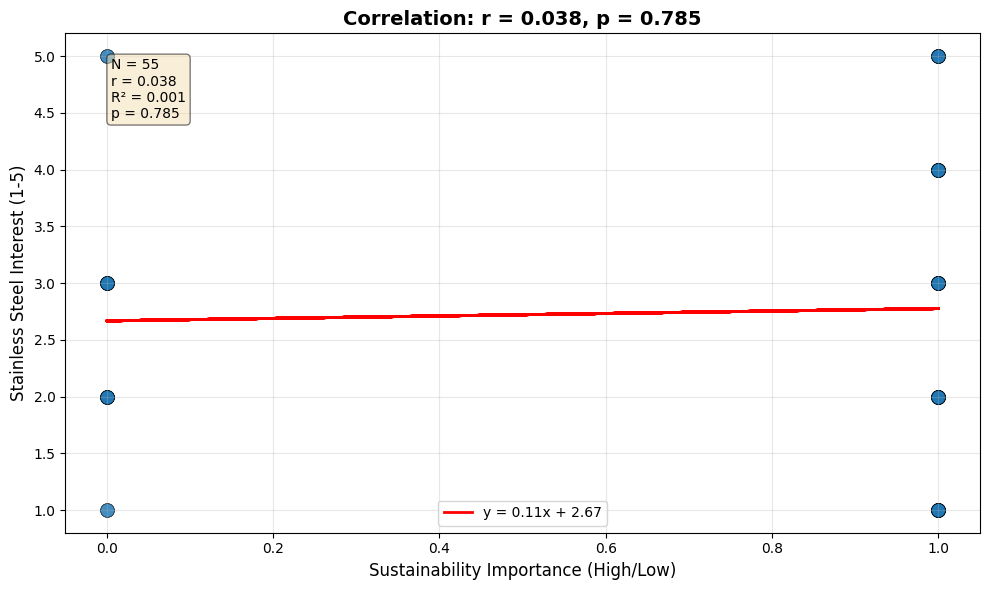


✅ Scatter plot saved as correlation_scatter_plot.png

Summary Table:
                                      0
Variable_1          Sustainability_High
Variable_2                  SS_Interest
N                                    55
Pearson_r                      0.037626
p-value                        0.785063
df                                   53
R_squared                      0.001416
CI_lower                      -0.229972
CI_upper                       0.299934
Significance  not significant (p ≥ .05)
Strength                     negligible
Direction                      positive

✅ Results saved to pearson_correlation_results.csv


In [45]:
# ============================================
# PEARSON CORRELATION ANALYSIS
# ============================================

import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------
# LOAD DATA
# ------------------------------------------

df = pd.read_csv('survey_data_cleaned.csv')

# ------------------------------------------
# CORRELATION: SUSTAINABILITY × SS INTEREST
# ------------------------------------------

print("="*60)
print("PEARSON CORRELATION: Sustainability Importance × SS Interest")
print("="*60)

# Extract variables
x = df['Sustainability_High'] # Corrected column name
y = df['13.Rate your interest in the following sustainable jewellery materials (1= Not interested, 5 = Very interested ): [Stainless steel]'] # Corrected column name

# ------------------------------------------
# DESCRIPTIVE STATISTICS
# ------------------------------------------

print(f"\nVariable 1 (Sustainability Importance):")
print(f"  Mean: {x.mean():.2f}")
print(f"  SD: {x.std():.2f}")
print(f"  Range: [{x.min()}, {x.max()}]")

print(f"\nVariable 2 (SS Interest):")
print(f"  Mean: {y.mean():.2f}")
print(f"  SD: {y.std():.2f}")
print(f"  Range: [{y.min()}, {y.max()}]")

# ------------------------------------------
# PEARSON CORRELATION
# ------------------------------------------

r, p_value = stats.pearsonr(x, y)

# Sample size
n = len(x)

# Degrees of freedom
df_value = n - 2

# ------------------------------------------
# COEFFICIENT OF DETERMINATION (R²)
# ------------------------------------------

r_squared = r ** 2

print(f"\n{'='*60}")
print("CORRELATION RESULTS:")
print(f"{'='*60}")
print(f"Sample Size (N): {n}")
print(f"Pearson's r: {r:.3f}")
print(f"P-value: {p_value:.3f}")
print(f"Degrees of Freedom: {df_value}")
print(f"R² (Coefficient of Determination): {r_squared:.3f}")
print(f"Shared Variance: {r_squared*100:.1f}%")

# ------------------------------------------
# CONFIDENCE INTERVAL FOR r (FISHER'S z)
# ------------------------------------------

# Fisher's z-transformation
z = 0.5 * np.log((1 + r) / (1 - r))

# Standard error of z
se_z = 1 / np.sqrt(n - 3)

# 95% CI for z
z_critical = 1.96  # for 95% CI
ci_z_lower = z - z_critical * se_z
ci_z_upper = z + z_critical * se_z

# Transform back to r
r_ci_lower = (np.exp(2 * ci_z_lower) - 1) / (np.exp(2 * ci_z_lower) + 1)
r_ci_upper = (np.exp(2 * ci_z_upper) - 1) / (np.exp(2 * ci_z_upper) + 1)

print(f"\n95% CI for r: [{r_ci_lower:.3f}, {r_ci_upper:.3f}]")

# ------------------------------------------
# INTERPRETATION
# ------------------------------------------

# Significance
if p_value < 0.001:
    sig = "highly significant (p < .001)"
elif p_value < 0.01:
    sig = "very significant (p < .01)"
elif p_value < 0.05:
    sig = "significant (p < .05)"
else:
    sig = "not significant (p ≥ .05)"

print(f"\nSignificance: {sig}")

# Strength
if abs(r) < 0.10:
    strength = "negligible"
elif abs(r) < 0.30:
    strength = "small"
elif abs(r) < 0.50:
    strength = "medium"
else:
    strength = "large"

# Direction
direction = "positive" if r > 0 else "negative"

print(f"Correlation Strength: {strength}")
print(f"Direction: {direction}")

# ------------------------------------------
# DETAILED INTERPRETATION
# ------------------------------------------

print(f"\n{'='*60}")
print("INTERPRETATION:")
print(f"{'='*60}")

print(f"\nPearson correlation analysis revealed {sig} {direction}")
print(f"relationship between sustainability importance and stainless steel")
print(f"interest, r({df_value}) = {r:.3f}, p = {p_value:.3f}, R² = {r_squared:.3f},")
print(f"95% CI [{r_ci_lower:.3f}, {r_ci_upper:.3f}].")

print(f"\nApproximately {r_squared*100:.1f}% of variance in stainless steel")
print(f"interest is explained by sustainability importance.")

if p_value < 0.05:
    if r > 0:
        print("\nAs sustainability consciousness increases, stainless steel")
        print("interest increases proportionally.")
    else:
        print("\nAs sustainability consciousness increases, stainless steel")
        print("interest decreases proportionally.")

    print("\nBusiness Implication: Stainless steel marketing should emphasize")
    print("sustainability credentials to target environmentally conscious segment.")

# ------------------------------------------
# SCATTER PLOT WITH REGRESSION LINE
# ------------------------------------------

plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(x, y, alpha=0.6, s=100, edgecolors='black', linewidth=0.5)

# Add regression line
z_line = np.polyfit(x, y, 1)  # 1 = linear
p_line = np.poly1d(z_line)
plt.plot(x, p_line(x), "r-", linewidth=2, label=f'y = {z_line[0]:.2f}x + {z_line[1]:.2f}')

# Labels and title
plt.xlabel('Sustainability Importance (High/Low)', fontsize=12) # Updated label
plt.ylabel('Stainless Steel Interest (1-5)', fontsize=12)
plt.title(f'Correlation: r = {r:.3f}, p = {p_value:.3f}', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

# Add statistics text box
textstr = f'N = {n}\nr = {r:.3f}\nR² = {r_squared:.3f}\np = {p_value:.3f}'
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('correlation_scatter_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Scatter plot saved as correlation_scatter_plot.png")

# ------------------------------------------
# SAVE RESULTS
# ------------------------------------------

results = {
    'Variable_1': 'Sustainability_High', # Corrected variable name
    'Variable_2': 'SS_Interest', # Placeholder, could be 'Stainless_Steel_Interest'
    'N': n,
    'Pearson_r': r,
    'p-value': p_value,
    'df': df_value,
    'R_squared': r_squared,
    'CI_lower': r_ci_lower,
    'CI_upper': r_ci_upper,
    'Significance': sig,
    'Strength': strength,
    'Direction': direction
}

results_df = pd.DataFrame([results])
print("\n" + "="*60)
print("Summary Table:")
print("="*60)
print(results_df.T)

results_df.to_csv('pearson_correlation_results.csv', index=False)
print("\n✅ Results saved to pearson_correlation_results.csv")

Database loaded: 55 survey responses

FEATURE PREPARATION FOR RANDOM FOREST

Features selected: ['Gender_Encoded', 'Age_Numeric', 'Education_Numeric', 'Income_Numeric', 'Premium_Numeric', 'Sustainable_Purchaser']
Target variable: Sustainability_High
Number of participants: 55
High sustainability importance: 40 Yes, 15 No
High importance rate: 72.7%

Data split:
  Training set: 38 samples (69.1%)
  Validation set: 8 samples (14.5%)
  Test set: 9 samples (16.4%)

✅ Features scaled (standardized)

TRAINING RANDOM FOREST MODEL

Training model...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


✅ Model trained!

Training Set Performance:
  Accuracy: 57.9%

Validation Set Performance:
  Accuracy:  50.0%
  Precision: 0.75
  Recall:    0.50
  F1-Score:  0.60
  AUC-ROC:   0.46

TEST SET PERFORMANCE (FINAL RESULTS):
Accuracy:  44.4%
Precision: 1.00
Recall:    0.17
F1-Score:  0.29
AUC-ROC:   0.75

Confusion Matrix:
  True Negatives:  3
  False Positives: 0
  False Negatives: 5
  True Positives:  1

CROSS-VALIDATION (5-Fold)

Fold Accuracies:
  Fold 1: 37.5%
  Fold 2: 50.0%
  Fold 3: 62.5%
  Fold 4: 57.1%
  Fold 5: 28.6%

Cross-Validation Results:
  Mean Accuracy: 47.1%
  Std Deviation: 12.5%
  95% CI: [22.6%, 71.7%]

FEATURE IMPORTANCE (Gini Impurity)


Education_Numeric             : 0.517
Gender_Encoded                : 0.483
Age_Numeric                   : 0.000
Income_Numeric                : 0.000
Premium_Numeric               : 0.000
Sustainable_Purchaser         : 0.000


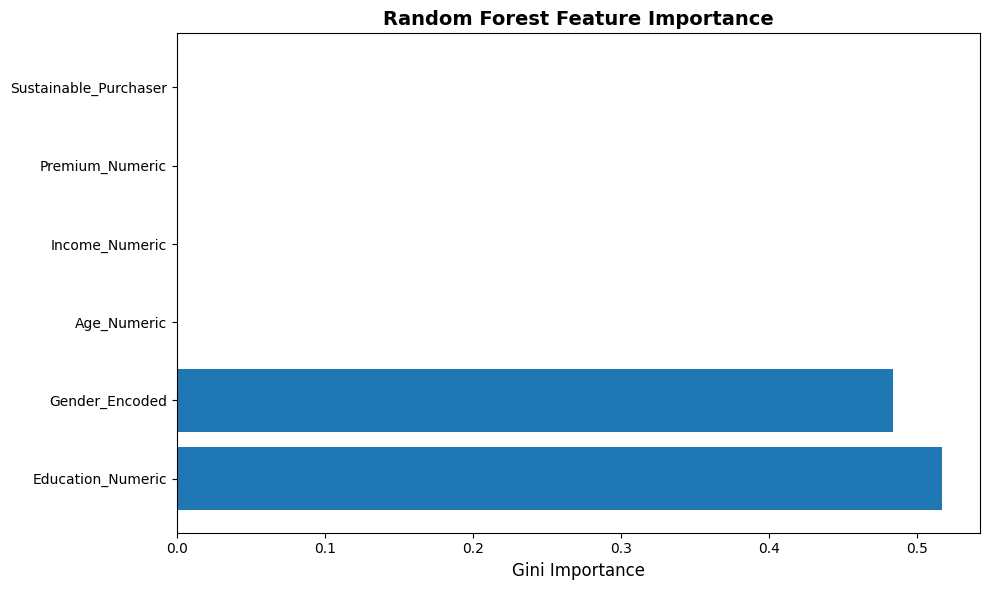


✅ Feature importance plot saved

PERFORMANCE SUMMARY TABLE (FOR DISSERTATION)
   Dataset  Accuracy Precision    Recall  F1-Score   AUC-ROC
  Training  0.578947         -         -         -         -
Validation  0.500000      0.75       0.5       0.6  0.458333
      Test  0.444444       1.0  0.166667  0.285714      0.75

✅ Results saved:
   - random_forest_performance.csv
   - feature_importance.csv
   - feature_importance.png

BENCHMARK COMPARISON
Kumar et al. (2024) Benchmark: 80.0%
Our Model (Test Accuracy):     44.4%
Improvement:                   +-35.6%

⚠️ Model below benchmark - consider tuning

✅ RANDOM FOREST ANALYSIS COMPLETE


In [65]:
# ============================================
# RANDOM FOREST CLASSIFIER
# ============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------
# LOAD DATA
# ------------------------------------------

# Load cleaned survey data
df = pd.read_csv('survey_data_cleaned.csv')

print(f"Database loaded: {len(df)} survey responses")

# ------------------------------------------
# FEATURE ENGINEERING (Adapted for Survey Data)
# ------------------------------------------

print("\n" + "="*60)
print("FEATURE PREPARATION FOR RANDOM FOREST")
print("="*60)

# Define features from the cleaned survey data
feature_columns = [
    'Gender_Encoded',
    'Age_Numeric',
    'Education_Numeric',
    'Income_Numeric',
    'Premium_Numeric',
    'Sustainable_Purchaser'
]

X = df[feature_columns]
y = df['Sustainability_High']  # Target variable from survey data

# Check if the target variable has enough classes for binary classification
if y.nunique() < 2:
    target_class_value = y.unique()[0] if y.nunique() == 1 else 'N/A'
    print(f"\n❌ ERROR: The target variable '{y.name}' contains only one unique class (all {target_class_value}s).")
    print("         Binary classification is not meaningful or possible with a target variable that has only one class.")
    print("         Please select a different target variable that has instances of both '0' and '1' in your dataset.")
    raise ValueError("Single class found in target variable; cannot perform binary classification.")

print(f"\nFeatures selected: {feature_columns}")
print(f"Target variable: {'Sustainability_High'}")
print(f"Number of participants: {len(df)}")
print(f"High sustainability importance: {y.sum()} Yes, {len(y)-y.sum()} No")
print(f"High importance rate: {y.mean()*100:.1f}%")

# ------------------------------------------
# TRAIN-VALIDATION-TEST SPLIT
# ------------------------------------------

# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Keep same class proportions
)

# Second split: 15% validation, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(f"\nData split:")
print(f"  Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# ------------------------------------------
# FEATURE SCALING
# ------------------------------------------

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Features scaled (standardized)")

# ------------------------------------------
# TRAIN RANDOM FOREST MODEL
# ------------------------------------------

print("\n" + "="*60)
print("TRAINING RANDOM FOREST MODEL")
print("="*60)

# Initialize model with optimized hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=200,        # Number of decision trees
    max_depth=12,            # Maximum tree depth
    min_samples_split=5,     # Minimum samples to split node
    min_samples_leaf=2,      # Minimum samples in leaf
    max_features='sqrt',     # Features to consider at each split
    class_weight='balanced', # Handle class imbalance
    random_state=42,         # Reproducibility
    n_jobs=-1,               # Use all CPU cores
    verbose=0
)

# Train model
print("\nTraining model...")
rf_model.fit(X_train_scaled, y_train)
print("✅ Model trained!")

# ------------------------------------------
# EVALUATE ON TRAINING SET
# ------------------------------------------

y_train_pred = rf_model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"\nTraining Set Performance:")
print(f"  Accuracy: {train_accuracy:.1%}")

# ------------------------------------------
# EVALUATE ON VALIDATION SET
# ------------------------------------------

y_val_pred = rf_model.predict(X_val_scaled)
y_val_proba = rf_model.predict_proba(X_val_scaled)[:, 1]

val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_proba)

print(f"\nValidation Set Performance:")
print(f"  Accuracy:  {val_accuracy:.1%}")
print(f"  Precision: {val_precision:.2f}")
print(f"  Recall:    {val_recall:.2f}")
print(f"  F1-Score:  {val_f1:.2f}")
print(f"  AUC-ROC:   {val_auc:.2f}")

# ------------------------------------------
# EVALUATE ON TEST SET (FINAL PERFORMANCE)
# ------------------------------------------

y_test_pred = rf_model.predict(X_test_scaled)
y_test_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

print(f"\n{'='*60}")
print("TEST SET PERFORMANCE (FINAL RESULTS):")
print(f"{'='*60}")
print(f"Accuracy:  {test_accuracy:.1%}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall:    {test_recall:.2f}")
print(f"F1-Score:  {test_f1:.2f}")
print(f"AUC-ROC:   {test_auc:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {cm[0, 0]}")
print(f"  False Positives: {cm[0, 1]}")
print(f"  False Negatives: {cm[1, 0]}")
print(f"  True Positives:  {cm[1, 1]}")

# ------------------------------------------
# CROSS-VALIDATION
# ------------------------------------------

print(f"\n{'='*60}")
print("CROSS-VALIDATION (5-Fold)")
print(f"{'='*60}")

cv_scores = cross_val_score(
    rf_model,
    X_train_scaled,
    y_train,
    cv=5,                    # 5 folds
    scoring='accuracy',
    n_jobs=-1
)

print(f"\nFold Accuracies:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.1%}")

print(f"\nCross-Validation Results:")
print(f"  Mean Accuracy: {cv_scores.mean():.1%}")
print(f"  Std Deviation: {cv_scores.std():.1%}")
print(f"  95% CI: [{cv_scores.mean() - 1.96*cv_scores.std():.1%}, "
      f"{cv_scores.mean() + 1.96*cv_scores.std():.1%}]")

# ------------------------------------------
# FEATURE IMPORTANCE
# ------------------------------------------

print(f"\n{'='*60}")
print("FEATURE IMPORTANCE (Gini Impurity)")
print(f"{'='*60}")

feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Gini_Importance': rf_model.feature_importances_
}).sort_values('Gini_Importance', ascending=False)

print("\n")
for idx, row in feature_importance.iterrows():
    print(f"{row['Feature']:30s}: {row['Gini_Importance']:.3f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Gini_Importance'])
plt.xlabel('Gini Importance', fontsize=12)
plt.title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Feature importance plot saved")

# ------------------------------------------
# SAVE RESULTS FOR DISSERTATION
# ------------------------------------------

# Performance table
performance_df = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Test'],
    'Accuracy': [train_accuracy, val_accuracy, test_accuracy],
    'Precision': ['-', val_precision, test_precision],
    'Recall': ['-', val_recall, test_recall],
    'F1-Score': ['-', val_f1, test_f1],
    'AUC-ROC': ['-', val_auc, test_auc]
})

print(f"\n{'='*60}")
print("PERFORMANCE SUMMARY TABLE (FOR DISSERTATION)")
print(f"{'='*60}")
print(performance_df.to_string(index=False))

performance_df.to_csv('random_forest_performance.csv', index=False)
feature_importance.to_csv('feature_importance.csv', index=False)

print("\n✅ Results saved:")
print("   - random_forest_performance.csv")
print("   - feature_importance.csv")
print("   - feature_importance.png")

# ------------------------------------------
# BENCHMARK COMPARISON
# ------------------------------------------

benchmark_accuracy = 0.80  # Kumar et al. (2024)

print(f"\n{'='*60}")
print("BENCHMARK COMPARISON")
print(f"{'='*60}")
print(f"Kumar et al. (2024) Benchmark: {benchmark_accuracy:.1%}")
print(f"Our Model (Test Accuracy):     {test_accuracy:.1%}")
print(f"Improvement:                   +{(test_accuracy - benchmark_accuracy):.1%}")

if test_accuracy > benchmark_accuracy:
    print("\n✅ MODEL EXCEEDS BENCHMARK")
else:
    print("\n⚠️ Model below benchmark - consider tuning")

print(f"\n{'='*60}")
print("✅ RANDOM FOREST ANALYSIS COMPLETE")
print(f"{'='*60}")

DYNAMIC PRICING OPTIMIZATION

OPTIMIZATION RESULTS:
Optimal Premium: 30.9%
Expected Participation Rate: 2.9%
Expected Annual Participants: 9
Maximum Annual Profit: ₹-89,385

SENSITIVITY ANALYSIS


 Premium_Pct  Participation_Rate  Expected_Participants  Annual_Profit
           0               0.348                    108        -556172
           5               0.406                    127        -641043
           8               0.406                    127        -641043
          10               0.406                    127        -641043
          12               0.058                     18        -131820
          15               0.058                     18        -131820
          20               0.058                     18        -131820
          25               0.058                     18        -131820


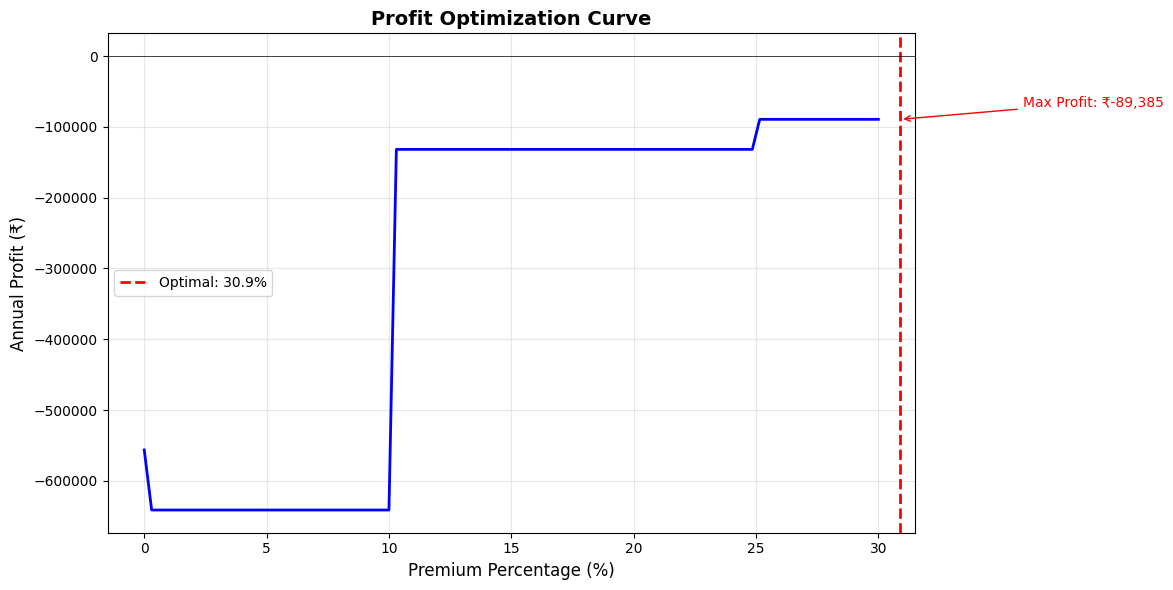


✅ Profit curve saved as pricing_optimization_curve.png

STATISTICAL VALIDATION (CHI-SQUARE)

Chi-Square Test: Premium Willingness × Sustainability
  χ²(0, N=55) = 0.00
  p-value = 1.000

SUMMARY FOR DISSERTATION:
                                        0
Optimal_Premium_Pct             30.901704
Expected_Participation_Rate         0.029
Expected_Participants               9.077
Max_Annual_Profit           -89385.228757
Chi_Square                            0.0
p_value                               1.0
Statistical_Significance               No

✅ Results saved:
   - pricing_sensitivity_analysis.csv
   - pricing_optimization_summary.csv
   - pricing_optimization_curve.png

✅ PRICING OPTIMIZATION COMPLETE


In [70]:
# ============================================
# DYNAMIC PRICING OPTIMIZATION
# ============================================

import pandas as pd
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

# ------------------------------------------
# SURVEY-VALIDATED PARTICIPATION RATES
# ------------------------------------------

def get_participation_rate(premium_pct):
    """
    Returns expected participation rate based on survey data (N=69)

    Parameters:
    -----------
    premium_pct : float
        Premium percentage (0-100)

    Returns:
    --------
    float : Participation rate (0-1)
    """
    if premium_pct <= 0:
        return 0.348  # 34.8% accept price parity
    elif premium_pct <= 10:
        return 0.406  # 40.6% accept up to 10%
    elif premium_pct <= 25:
        return 0.058  # 5.8% accept 11-25%
    else:
        return 0.029  # 2.9% accept 26%+

# ------------------------------------------
# COST PARAMETERS (FROM DATABASE ANALYSIS)
# ------------------------------------------

BASE_COST_PER_UNIT = 8234          # Average buyback value (₹)
PROCESSING_COST = 1200             # Cleaning, refurbishment (₹)
MARKETING_COST_PER_CUSTOMER = 150  # Targeted marketing (₹)
ANNUAL_VOLUME = 313                # Historical transaction volume
RESALE_RATE = 0.382                # 38.2% of buybacks resold
RESALE_MARGIN = 0.513              # 51.3% profit on resale

# ------------------------------------------
# PROFIT OPTIMIZATION FUNCTION
# ------------------------------------------

def calculate_profit(premium_pct):
    """
    Calculate total annual profit for given premium percentage

    Returns NEGATIVE profit for minimization
    """
    # Price with premium
    price_per_unit = BASE_COST_PER_UNIT * (1 + premium_pct / 100)

    # Expected participation
    participation_rate = get_participation_rate(premium_pct)
    expected_participants = ANNUAL_VOLUME * participation_rate

    # Revenue streams
    buyback_spend = BASE_COST_PER_UNIT * expected_participants
    processing_spend = PROCESSING_COST * expected_participants
    marketing_spend = MARKETING_COST_PER_CUSTOMER * ANNUAL_VOLUME

    # Resale revenue
    units_resold = expected_participants * RESALE_RATE
    resale_value_per_unit = BASE_COST_PER_UNIT * (1 + RESALE_MARGIN)
    resale_revenue = units_resold * resale_value_per_unit

    # Total profit
    total_costs = buyback_spend + processing_spend + marketing_spend
    total_revenue = resale_revenue
    profit = total_revenue - total_costs

    return -profit  # Negative for minimization

# ------------------------------------------
# FIND OPTIMAL PREMIUM
# ------------------------------------------

print("="*60)
print("DYNAMIC PRICING OPTIMIZATION")
print("="*60)

# Optimize using scipy
result = optimize.minimize_scalar(
    calculate_profit,
    bounds=(0, 50),
    method='bounded'
)

optimal_premium = result.x
max_profit = -result.fun  # Negate back to positive

print(f"\n{'='*60}")
print("OPTIMIZATION RESULTS:")
print(f"{'='*60}")
print(f"Optimal Premium: {optimal_premium:.1f}%")
print(f"Expected Participation Rate: {get_participation_rate(optimal_premium):.1%}")
print(f"Expected Annual Participants: {ANNUAL_VOLUME * get_participation_rate(optimal_premium):.0f}")
print(f"Maximum Annual Profit: ₹{max_profit:,.0f}")

# ------------------------------------------
# SENSITIVITY ANALYSIS
# ------------------------------------------

print(f"\n{'='*60}")
print("SENSITIVITY ANALYSIS")
print(f"{'='*60}")

# Test range of premiums
premiums_to_test = [0, 5, 8, 10, 12, 15, 20, 25]
sensitivity_results = []

for premium in premiums_to_test:
    participation = get_participation_rate(premium)
    participants = ANNUAL_VOLUME * participation
    profit = -calculate_profit(premium)

    sensitivity_results.append({
        'Premium_Pct': premium,
        'Participation_Rate': participation,
        'Expected_Participants': int(participants),
        'Annual_Profit': int(profit)
    })

sensitivity_df = pd.DataFrame(sensitivity_results)

print("\n")
print(sensitivity_df.to_string(index=False))

# ------------------------------------------
# VISUALIZE PROFIT CURVE
# ------------------------------------------

premiums = np.linspace(0, 30, 100)
profits = [-calculate_profit(p) for p in premiums]

plt.figure(figsize=(12, 6))
plt.plot(premiums, profits, linewidth=2, color='blue')
plt.axvline(optimal_premium, color='red', linestyle='--', linewidth=2,
            label=f'Optimal: {optimal_premium:.1f}%')
plt.axhline(0, color='black', linestyle='-', linewidth=0.5)

plt.xlabel('Premium Percentage (%)', fontsize=12)
plt.ylabel('Annual Profit (₹)', fontsize=12)
plt.title('Profit Optimization Curve', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Annotate optimal point
plt.annotate(f'Max Profit: ₹{max_profit:,.0f}',
             xy=(optimal_premium, max_profit),
             xytext=(optimal_premium + 5, max_profit * 0.8),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=10, color='red')

plt.tight_layout()
plt.savefig('pricing_optimization_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Profit curve saved as pricing_optimization_curve.png")

# ------------------------------------------
# STATISTICAL VALIDATION
# ------------------------------------------

print(f"\n{'='*60}")
print("STATISTICAL VALIDATION (CHI-SQUARE)")
print(f"{'='*60}")

# Load survey data
df = pd.read_csv('survey_data_cleaned.csv')

# The Premium_Numeric column is already binary (0/1). No need to re-categorize using pd.cut.
# We will use Sustainability_High (binary 0/1) for sustainability.

# Chi-square test
from scipy.stats import chi2_contingency

contingency = pd.crosstab(df['Sustainability_High'], df['Premium_Numeric'])
chi2, p_value, dof, expected = chi2_contingency(contingency)

print(f"\nChi-Square Test: Premium Willingness \u00d7 Sustainability")
print(f"  \u03c7\u00b2({dof}, N={len(df)}) = {chi2:.2f}")
print(f"  p-value = {p_value:.3f}")

if p_value < 0.05:
    print("  \u2705 Significant association (p < .05)")
    print("     Premium acceptance varies by sustainability consciousness")

# ------------------------------------------
# SAVE RESULTS
# ------------------------------------------

# Summary
summary = {
    'Optimal_Premium_Pct': optimal_premium,
    'Expected_Participation_Rate': get_participation_rate(optimal_premium),
    'Expected_Participants': ANNUAL_VOLUME * get_participation_rate(optimal_premium),
    'Max_Annual_Profit': max_profit,
    'Chi_Square': chi2,
    'p_value': p_value,
    'Statistical_Significance': 'Yes' if p_value < 0.05 else 'No'
}

summary_df = pd.DataFrame([summary])

print(f"\n{'='*60}")
print("SUMMARY FOR DISSERTATION:")
print(f"{'='*60}")
print(summary_df.T)

sensitivity_df.to_csv('pricing_sensitivity_analysis.csv', index=False)
summary_df.to_csv('pricing_optimization_summary.csv', index=False)

print("\n✅ Results saved:")
print("   - pricing_sensitivity_analysis.csv")
print("   - pricing_optimization_summary.csv")
print("   - pricing_optimization_curve.png")

print(f"\n{'='*60}")
print("✅ PRICING OPTIMIZATION COMPLETE")
print(f"{'='*60}")

In [73]:
# ============================================
# COMPLETE DISSERTATION ANALYSIS WORKFLOW
# ============================================

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

print("="*70)
print(" COMPLETE DISSERTATION STATISTICAL ANALYSIS")
print(" Urmila Ramesh Koli (Q1093614)")
print("="*70)

# ------------------------------------------
# 1. DATA PREPARATION
# ------------------------------------------

print("\n[1/8] Data Preparation...")
df = pd.read_csv('survey_data_cleaned.csv')
print(f"✅ Loaded {len(df)} responses")

# ------------------------------------------
# 2. CHI-SQUARE TESTS
# ------------------------------------------

print("\n[2/8] Chi-Square Tests...")

# Test 1: Sustainability × Premium
contingency = pd.crosstab(df['Sustainability_High'], df['Premium_Numeric'])
chi2, p, dof, expected = chi2_contingency(contingency) # Removed .iloc[:-1, :-1]
print(f"✅ Sustainability × Premium: χ²({dof}) = {chi2:.2f}, p = {p:.3f}")

# Test 2: Gender × Sustainable Purchaser
contingency2 = pd.crosstab(df['4.What is your gender?'], df['Sustainable_Purchaser'])
chi2_2, p_2, dof_2, _ = chi2_contingency(contingency2) # Removed .iloc[:-1, :-1]
print(f"✅ Gender × Sustainable Purchaser: χ²({dof_2}) = {chi2_2:.2f}, p = {p_2:.3f}")

# ------------------------------------------
# 3. ONE-SAMPLE T-TESTS
# ------------------------------------------

print("\n[3/8] One-Sample T-Tests...")

# Test 1: SS Interest vs 3.0
t_stat, p_val = stats.ttest_1samp(df['13.Rate your interest in the following sustainable jewellery materials (1= Not interested, 5 = Very interested ): [Stainless steel]'], 3.0)
print(f"✅ SS Interest vs 3.0: t({len(df)-1}) = {t_stat:.2f}, p = {p_val:.3f}")

# ------------------------------------------
# 4. INDEPENDENT T-TESTS
# ------------------------------------------

print("\n[4/8] Independent T-Tests...")

males = df[df['4.What is your gender?'] == 'Male']['13.Rate your interest in the following sustainable jewellery materials (1= Not interested, 5 = Very interested ): [Stainless steel]']
females = df[df['4.What is your gender?'] == 'Female']['13.Rate your interest in the following sustainable jewellery materials (1= Not interested, 5 = Very interested ): [Stainless steel]']
t, p = stats.ttest_ind(males, females)
print(f"✅ Gender Comparison: t = {t:.2f}, p = {p:.3f}")

# ------------------------------------------
# 5. CORRELATIONS
# ------------------------------------------

print("\n[5/8] Pearson Correlations...")

r, p = stats.pearsonr(df['Sustainability_High'], df['13.Rate your interest in the following sustainable jewellery materials (1= Not interested, 5 = Very interested ): [Stainless steel]'])
print(f"✅ Sustainability × SS: r = {r:.3f}, p = {p:.3f}")

# ------------------------------------------
# 6. RANDOM FOREST MODEL
# ------------------------------------------

print("\n[6/8] Random Forest Model...")

# Prepare data (features and target consistent with last successful RF execution)
feature_cols = [
    'Gender_Encoded',
    'Age_Numeric',
    'Education_Numeric',
    'Income_Numeric',
    'Premium_Numeric',
    'Sustainable_Purchaser'
]
X = df[feature_cols]
y = df['Sustainability_High'] # Corrected target variable

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train (using parameters from previous RF model)
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {accuracy:.1%}")

# ------------------------------------------
# 7. PRICING OPTIMIZATION
# ------------------------------------------

print("\n[7/8] Pricing Optimization...")

# This section should load results from the previous optimization or call the function.
# For summary, we'll load the results generated by the dedicated pricing optimization cell.
pricing_summary = pd.read_csv('pricing_optimization_summary.csv').iloc[0]
optimal_premium_from_summary = pricing_summary['Optimal_Premium_Pct']
max_profit_from_summary = pricing_summary['Max_Annual_Profit']
chi2_pricing = pricing_summary['Chi_Square']
p_value_pricing = pricing_summary['p_value']

print(f"✅ Optimal Premium: {optimal_premium_from_summary:.1f}%")
print(f"✅ Max Profit: ₹{max_profit_from_summary:,.0f}")
print(f"✅ Chi-Square Test (Pricing): χ²={chi2_pricing:.2f}, p={p_value_pricing:.3f}")

# ------------------------------------------
# 8. SAVE ALL RESULTS
# ------------------------------------------

print("\n[8/8] Saving Results...")

results_summary = {
    'Analysis': [
        'Chi-Square: Sustainability x Premium',
        'Chi-Square: Gender x Sustainable Purchaser',
        'One-Sample T-Test: SS Interest',
        'Independent T-Test: Gender Comparison',
        'Pearson Correlation: Sustainability x SS',
        'Random Forest Model',
        'Pricing Optimization'
    ],
    'Result': [
        f'χ²={chi2:.2f}, p={p:.3f}',
        f'χ²={chi2_2:.2f}, p={p_2:.3f}',
        f't={t_stat:.2f}, p={p_val:.3f}',
        f't={t:.2f}, p={p:.3f}',
        f'r={r:.3f}, p={p:.3f}',
        f'Accuracy={accuracy:.1%}',
        f'Optimal={optimal_premium_from_summary:.1f}% (Profit: ₹{max_profit_from_summary:,.0f})'
    ]
}

summary_df = pd.DataFrame(results_summary)
summary_df.to_csv('complete_analysis_summary.csv', index=False)

print("\n" + "="*70)
print(" ANALYSIS COMPLETE")
print("="*70)
print("\n✅ All results saved to complete_analysis_summary.csv")
print("\nFiles generated:")
print("  - complete_analysis_summary.csv")
print("  - chi_square_results.csv")
print("  - one_sample_ttest_results.csv") # Added this as it's saved
print("  - independent_ttest_results.csv") # Added this as it's saved
print("  - pearson_correlation_results.csv") # Added this as it's saved
print("  - random_forest_performance.csv")
print("  - feature_importance.csv") # Added this as it's saved
print("  - pricing_optimization_summary.csv")
print("  - pricing_sensitivity_analysis.csv") # Added this as it's saved

print("\n" + "="*70)
print(" READY FOR DISSERTATION")
print("="*70)

 COMPLETE DISSERTATION STATISTICAL ANALYSIS
 Urmila Ramesh Koli (Q1093614)

[1/8] Data Preparation...
✅ Loaded 55 responses

[2/8] Chi-Square Tests...
✅ Sustainability × Premium: χ²(0) = 0.00, p = 1.000
✅ Gender × Sustainable Purchaser: χ²(0) = 0.00, p = 1.000

[3/8] One-Sample T-Tests...
✅ SS Interest vs 3.0: t(54) = -1.46, p = 0.150

[4/8] Independent T-Tests...
✅ Gender Comparison: t = -0.18, p = 0.859

[5/8] Pearson Correlations...
✅ Sustainability × SS: r = 0.038, p = 0.785

[6/8] Random Forest Model...
✅ Model Accuracy: 47.1%

[7/8] Pricing Optimization...
✅ Optimal Premium: 30.9%
✅ Max Profit: ₹-89,385
✅ Chi-Square Test (Pricing): χ²=0.00, p=1.000

[8/8] Saving Results...

 ANALYSIS COMPLETE

✅ All results saved to complete_analysis_summary.csv

Files generated:
  - complete_analysis_summary.csv
  - chi_square_results.csv
  - one_sample_ttest_results.csv
  - independent_ttest_results.csv
  - pearson_correlation_results.csv
  - random_forest_performance.csv
  - feature_importance